# Fundamentals of Finite Volume for TDEM Simulations

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

```{admonition} Prerequisite Tutorials
:class: note
[1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb)
```

**Author:** Devin C. Cowan

</br>

**Keywords:** finite volume fundamentals, TDEM, forward simulation, time discretization, mesh discretization.

</br>

**Summary:** Successful forward simulation of TDEM data using mimetic finite volume requires reasonable values for a multitude of input parameters. More specifically, the parameters which determine how our numerical scheme is discretized in space and in time. When choosing parameters values for the TDEM forward simulation, we aim find an optimum balance between:

* numerical accuracy, and
* required computational resources (e.g. run-time, memory)

This tutorial does not focus on the syntax for generating and using the SimPEG objects required for TDEM forward simulations. We assume the user has worked through the [1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb) tutorial and is already familiar with generating waveform, source, receiver, survey and simulation objects. Since designing the survey and choosing an appropriate simulation class are problem-dependent, we will cover this in separate tutorials. 

Here, we introduce guidelines for discretizing TDEM problems in space and in time that can be applied in most cases. We then demonstrate how our choices with regards to discretization impact TDEM forward simulations. To limit the computation time required to run the tutorial, all simulations are performed on a [Cylindrical Mesh](myst:discretize#discretize.CylindricalMesh). However, the knowledge gained here can be applied regardless of the mesh type (e.g. [Tensor Mesh](myst:discretize#discretize.TensorMesh), [Tree Mesh](myst:discretize#discretize.TreeMesh)).

</br>

**Learning Objectives:**

- Using observation times and subsurface conductivity to generate an appropriate mesh.
- Defining the time discretization during the off-time.
- Defining the time discretization during a waveform's on-time.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to TDEM is imported from [SimPEG.electromagnetics.time_domain](myst:SimPEG#SimPEG.electromagnetics.time_domain). We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils).

In [1]:
# SimPEG functionality
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps

# discretize functionality
from discretize import CylindricalMesh, TensorMesh
from discretize.utils import mkvc

# Common Python functionality
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})

## Defining the Simulation Geometry

Here, we define the problem geometry that will be used throughout the tutorial. The problem geometry consists of a horizontal circular transmitter loop with a radius of 25 m, located on the Earth's surface. Data are simulated at the center of the loop for a set of logarithmically-spaced time channels between 1e-5 s and 1e-3 s. The subsurface electrical conductivity is characterized by a 1e-2 S/m halfspace.

In [2]:
# Source properties
source_location = np.array([0.0, 0.0, 0.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current (A)
source_radius = 25.0  # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 0.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
time_channels = np.logspace(-5, -3, 21)  # time channels (s)

# Model properties
halfspace_conductivity = 1e-2  # Halfspace conductivity (S/m)

## Defining Some Useful Functions

### Generate the Survey

For the [waveform object](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.BaseWaveform) and field type provided, this function generates the [TDEM survey object](myst:SimPEG#SimPEG.electromagnetics.time_domain.survey.Survey) for our problem geometry when called.

In [3]:
def generate_survey(waveform_object):
    # Define receiver
    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_locations, time_channels, orientation=receiver_orientation
        )
    ]

    # Define loop source
    source_list = [
        tdem.sources.CircularLoop(
            receiver_list=receiver_list,
            location=source_location,
            waveform=waveform_object,
            current=source_current,
            radius=source_radius,
        )
    ]

    return tdem.Survey(source_list)

### Generate the Mesh, Model and Mapping

For the minimum cell size *dh*, minimum diffusion distance *d_min* and maximum diffusion distance *d_max*, this function generates a [Cylindrical Mesh](myst:discretize#discretize.CylindricalMesh). The extent of the core region is 8 times the smallest diffusion distance. The padding thickness is 2 times the largest diffusion distance and a padding factor of 1.25 is used. For more, visit the [discretize tutorial on cylindrical meshes](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/3_cylindrical_mesh.html).

In [4]:
def generate_discretization(dh, d_min, d_max):
    # Number of core mesh cells
    n_core = np.floor(8 * d_min / dh)

    # Number of padding cells
    n_pad = 1
    pad_factor = 1.25
    while sum(dh * pad_factor ** np.arange(n_pad)) < 2 * d_max:
        n_pad += 1

    # Radial and vertical discretization
    hr = [(dh, n_core), (dh, n_pad, 1.2)]
    hz = [(dh, n_pad, -pad_factor), (dh, 2 * n_core), (dh, n_pad, pad_factor)]

    # Generate mesh
    mesh = CylindricalMesh([hr, 1, hz], x0="00C")

    # Active cells
    active_cells = mesh.cell_centers[:, -1] < 0.0

    # Halfspace conductivity model
    model = halfspace_conductivity * np.ones(np.sum(active_cells))

    # Mapping from conductivity model to mesh
    mapping = maps.InjectActiveCells(mesh, active_cells, 1e-8)

    return mesh, model, mapping

## Part 1: Discretization in Space (cell size)

Here, we investigate the impact of minimum cell size on the accuracy of the forward simulation. It is obvious that finer cells will reduce the error in the numerical forward simulation. However, overly fine discretization can produce meshes that make the numerical forward simulation untenable. For instance, by decreasing the widths of the cells in a mesh by a factor of 2, the number of cells in a 2D tensor mesh will increase by a factor of 4, and the number of cells in a 3D tensor mesh will increase by a factor of 8. So when choosing the parameters that define the mesh, we aim find an optimum balance between:

* numerical accuracy, and
* required computational resources (e.g. run-time, memory)

For the problem geometry described in the introduction, we simulate $\partial b_z/\partial t$ at the source loop's center for a step-off excitation. When generating an appropriate mesh for the simulation, we consider the [diffusion distance](https://em.geosci.xyz/content/maxwell1_fundamentals/transient_planewaves_homogeneous/peakdistance.html):

$$
d = \sqrt{\frac{2 t}{\mu \sigma}} \approx 1260 \sqrt{\frac{t}{\sigma}}
$$

which defines the distance the peak amplitude of a planewave has traveled within a homogeneous medium at time *t* after an initial step excitation. For times 1e-6 s, 1e-5 s and 1e-4 s, this is illustrated in the figure below.

At early times, we see the signal is compact and the diffusion distance is small. So to model the physics accurately at early times, finer spatial sampling (i.e. discretization) within the region of the signal is required. At later times, the signal has diffused and become smooth, and the diffusion distance is larger. So at larger distances from the source, where the signal is smooth and is not present until later times, we can use a coarser discretization and still model the physics accurately. Note that in more conductive media, the diffusion distance is smaller and a finer discretization is required.

```{figure} ../../assets/website_images/diffusion_distance.png
:width: 800px
:align: center

Propagation and diffusion of a planewave within a homogeneous medium.
```

**Standard Approach:** 

*1) Minimum cell size:* use the earliest time channel in the survey and the highest conductivity for your geophysical scenario to compute the minimum diffusion distance, i.e.:

$$
d_{min} \approx 1260 \sqrt{\frac{t_{min}}{\sigma_{max}}}
$$

The minimum cell size **must** be equal or smaller than the minimum skin depth; i.e. $\Delta h_{min} \leq d_{min}$. Due to interpolation error, there should also be several cells between any controlled source and its receiver(s); which can result in minimum cell sizes that are much smaller than the minimum diffusion distance.

*2) Discretization within the core region:* The core region describes the region containing structures whose responses you wish to simulate. Further away from any controlled source, the fields are smoother and we can use a coarser discretization. But what is the rate at which we can increase the cell widths?

   * [Cylindrical Meshes](myst:discretize#discretize.CylindricalMesh) and [Tensor Meshes](myst:discretize#discretize.TensorMesh): In this case, the minimum cell size is used throughout the entire core mesh region. Based on the size of the problem, the thickness of this region is some multiple of the minimum diffusion distance for the simulation.
   * [Tree Meshes](myst:discretize#discretize.TreeMesh): In this case, cell size can increase linearly with respect to distance from any controlled source. However it is important not to increase the cell size too quickly. You should have a layer at least 4 cells thick before increasing the cell size again within the core mesh region.

As an additional note, the dimensions of the cells within the core mesh region should **never** exceed an aspect ratio of 2:1. 

*3. Mesh boundaries:* The natural boundary conditions for TDEM simulations in SimPEG require the user to define the boundaries of the mesh sufficiently far from any controlled source. To define appropriate boundaries for the mesh, use the latest time channel and host conductivity to compute the largest diffusion distance, i.e.:

$$
d_{max} \approx 1260 \sqrt{\frac{t_{max}}{\sigma_{host}}}
$$

The padding region between the survey and the edge of the mesh **must** be 2-3 times the largest diffusion distance. Because the fields within this padding region are smooth, we can used a very coarse discretization.

   * [Cylindrical Meshes](myst:discretize#discretize.CylindricalMesh) and [Tensor Meshes](myst:discretize#discretize.TensorMesh): In this case, the widths of the cells along each direction are increased successively by a constant factor. We advise using a factor that is $\leq 1.5$.
   * [Tree Meshes](myst:discretize#discretize.TreeMesh): Tree meshes will pad out naturally. So long as the core mesh region extends sufficiently far, you can expect reasonable accuracy at late times.

### Compute the Diffusion Distances

Here, we compute the minimum and maximum diffusion distances for the forward simulation. Here, we only have to consider the diffusion distances for a halfspace. As we can see, the minimum diffusion distance is 39.8 m. And the maximum diffusion distance is 398.4 m.

In [5]:
diffusion_distances = 1260 * np.sqrt(time_channels / halfspace_conductivity)
d_min = diffusion_distances.min()
d_max = diffusion_distances.max()
print("DIFFUSION DISTANCES: {}".format(np.round(diffusion_distances, 1)))

DIFFUSION DISTANCES: [ 39.8  44.7  50.2  56.3  63.1  70.9  79.5  89.2 100.1 112.3 126.  141.4
 158.6 178.  199.7 224.1 251.4 282.1 316.5 355.1 398.4]


### Define Minimum Cell Widths

To validate the standard approach, forward simulations are performed using minimum cell sizes equal to:

$$
\Delta h_{min} = \left \{ 4\, d_{min}, \; 2\, d_{min}, \; d_{min}, \; 0.5\, d_{min}, \; 0.25\, d_{min} \right \}
$$

Here, we define the list containing the minimum cell size used in each forward simulation.

In [6]:
size_factor = [4.0, 2.0, 1.0, 0.5, 0.25]
dh_min = [c * d_min for c in size_factor]

### Define the Waveform

Here, we define the [stepoff waveform object](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.StepOffWaveform) that is used in the forward simulations. This waveform assumes a constant current of 1 A at time $t \leq 0$.

In [7]:
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

### Numerical Solution

Here, we perform the forward simulation for the set of minimum cell widths $\Delta h_{min}$ and store the predicted data in list *dpred_1*. For minimum cell width, we must:

* define a new mesh, model and mapping.
* define the simulation.
* predict data for the halfspace conductivity model.

We have automatically set a reasonable time-discretization for the problem. The impact of time-discretization is demonstrated in Part 2.

In [8]:
dpred_1 = []

for dh in dh_min:
    # Generate mesh, model and mapping
    mesh, model, mapping = generate_discretization(dh, d_min, d_max)

    # Define the simulation
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(stepoff_waveform),
        sigmaMap=mapping,
        time_steps=[(5e-07, 40), (2.5e-06, 40), (1.25e-05, 81)],
    )

    # Simulate the data
    dpred_1.append(simulation.dpred(model))

    print("N_CELLS: {} | dh = {} m".format(mesh.nC, dh))

N_CELLS: 72 | dh = 159.3787940724863 m
N_CELLS: 200 | dh = 79.68939703624315 m
N_CELLS: 578 | dh = 39.844698518121575 m
N_CELLS: 1458 | dh = 19.922349259060788 m
N_CELLS: 4232 | dh = 9.961174629530394 m


### Semi-Analytic 1D Solution

Here, the [Simulation1DLayered](myst:SimPEG#SimPEG.electromagnetics.time_domain.Simulation1DLayered) simulation class is used to simulate the semi-analytic solution for our problem.

In [9]:
simulation_1d = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(stepoff_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1),
)

dtrue_stepoff = simulation_1d.dpred(np.array([halfspace_conductivity]))

### Results

Here, we plot the 1D solution and the numerical solutions for different minimum cell widths. As we can see, sufficient numerical accuracy is obtained when the minimum cell width is equal to or smaller than the minimum diffusion distance; i.e. when $\Delta h_{min} \leq d_{min}$.

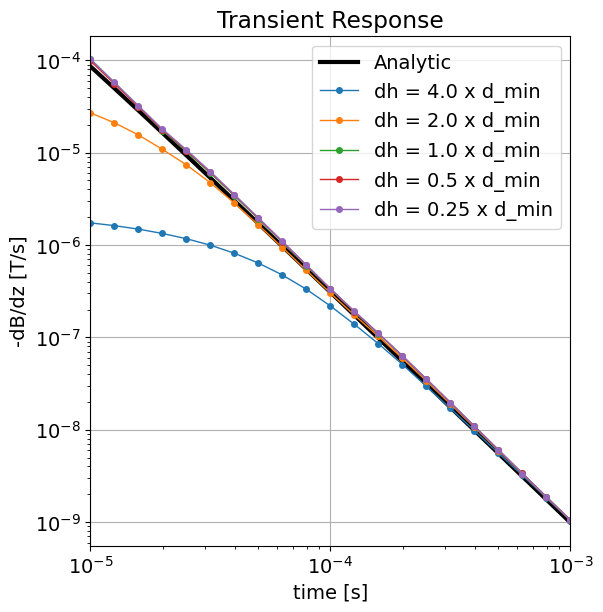

In [10]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
ax1.loglog(time_channels, -dtrue_stepoff, "k", lw=3)
for d in dpred_1:
    ax1.loglog(time_channels, -d, "-o", lw=1, markersize=4)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dB/dz [T/s]")
ax1.set_title("Transient Response")
ax1.legend(["Analytic"] + ["dh = {} x d_min".format(c) for c in size_factor])
plt.show()

## Part 2: Discretization in Time (off-time)

In SimPEG, time-stepping is currently carried out using [Backward Euler](https://en.wikipedia.org/wiki/Backward_Euler_method). Backward Euler is used because 1) it is stable when stepping forward in time regardless of step-length, and 2) it only requires the storage of a single factorization of a matrix inverse for each unique step length. Here, we investigate the impact of time-step size on the accuracy of the forward simulation.

When choosing a time-stepping scheme, our goals are to:

* Minimize the number of time-steps
* Minimize the number of unique step lengths

Although smaller time-steps will reduce the error in the numerical forward simulation, a linear system must be solves at every time-step. Run-times can therefore become very large when the step-size is too small. Since the Earth's TDEM response is characterized by a set of exponential decays, we can reduced the total number of time-steps by using smaller time-steps at early times and larger time-steps at later times. However, a linear system must be factored and stored for each unique time-step length. Not only does each factorization take significant time, it may require significant computer memory.

**Standard Approach:** Assume the off-time begins at t = 0 s.

1. Consider your earliest time channel. The minimum time-step length should be 5-10\% of the earliest time channel. Use this step length until just after your first time channel.
2. Increase the time-step length by a factor of 3-6; any more and you will produce artifacts. Use this step length over the next decade of time channels.
3. Repeat until you have at least 1 time step beyond your latest time channel.

If applied correctly, and you have time channels spanning *N* decades, this will result in *N+1* unique step lengths. Our suggested approach generally strikes a reasonable balance between limiting the number of time-steps and the number of unique time-step lengths.

### Define Minimum Time-Step Lengths

To validate the standard approach, forward simulations are performed using various minimum time-step lengths. Where $t_{min}$ is the earliest time channel, we test minimum time-step lengths of:

$$
\Delta t_{min} = \left \{ \frac{t_{min}}{5}, \; \frac{t_{min}}{10}, \; \frac{t_{min}}{20}, \; \frac{t_{min}}{40}, \; \frac{t_{min}}{80} \right \}
$$

At each decade, we increase the time-step size by a factor of 5.

In [11]:
t_min = time_channels.min()  # Earliest time channel

size_factor = [5, 10, 20, 40, 80]
dt_min = [t_min / c for c in size_factor]  # minimum time-step lengths

### Numerical Solution

Here, we perform the forward simulation for a set of minimum time-step lengths $\Delta t_{min}$ and store the predicted data in list *dpred_2*. In accordance with our findings in Part 1, we use a minimum cell size $\Delta h_{min}$ equal to the smallest diffusion distance $d_{min}$.

In [12]:
# Store the predicted data and time steps
dpred_2 = []
simulation_times = []

# Define the mesh, model and mapping
mesh, model, mapping = generate_discretization(d_min, d_min, d_max)

for dt in dt_min:
    # Define the simulation
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(stepoff_waveform),
        sigmaMap=mapping,
    )

    # Set the time steps
    time_steps = [
        (dt, int(1.05 * t_min / dt)),
        (5 * dt, int(10 * t_min / (5 * dt) + 1)),
        (25 * dt, int(100 * t_min / (25 * dt) + 1)),
    ]
    simulation.time_steps = time_steps

    # Store the time steps
    simulation_times.append(simulation.times[1:])

    # Simulate the data
    dpred_2.append(simulation.dpred(model))

    print("N_TIMES: {}".format(simulation.nT))

N_TIMES: 35
N_TIMES: 70
N_TIMES: 141
N_TIMES: 282
N_TIMES: 564


### Results

Below, we plot the time-steps used for each simulation and the predicted data. As we can see, a minimum time-step length smaller than $\dfrac{t_{min}}{20}$ is required to produce reasonable accuracy.

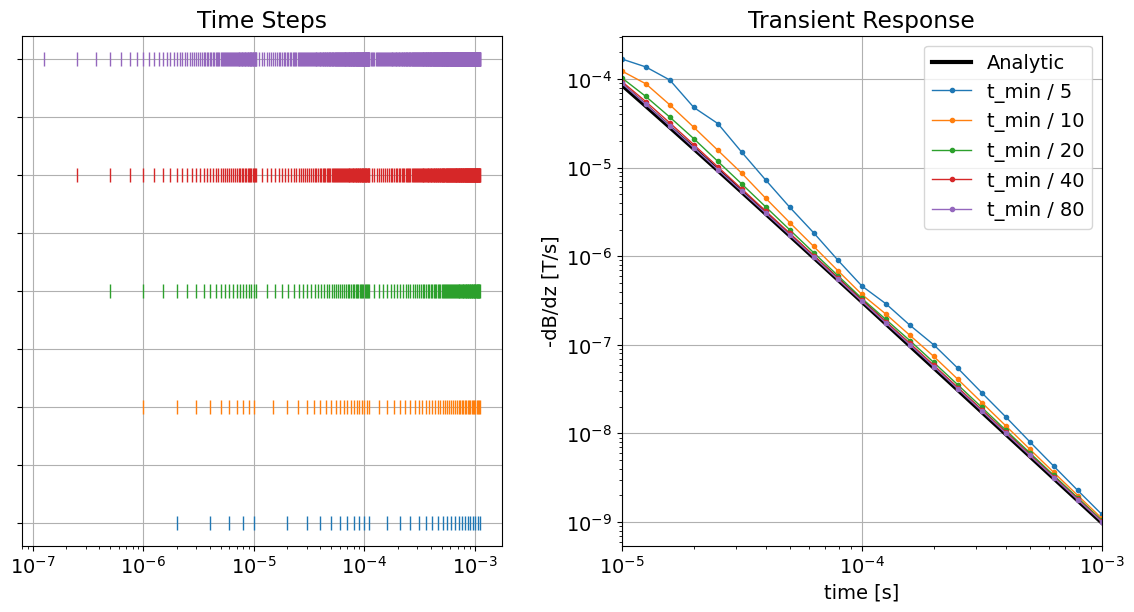

In [13]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
for ii, tvec in enumerate(simulation_times):
    ax1.semilogx(tvec, ii * np.ones_like(tvec), "|", markersize=10)
ax1.set_yticklabels([])
ax1.set_title("Time Steps")
ax1.grid()

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.loglog(time_channels, -dtrue_stepoff, "k", lw=3)
for d in dpred_2:
    ax2.loglog(time_channels, -d, "-o", lw=1, markersize=3)
ax2.set_xlim((np.min(time_channels), np.max(time_channels)))
ax2.grid()
ax2.set_xlabel("time [s]")
ax2.set_ylabel("-dB/dz [T/s]")
ax2.set_title("Transient Response")
ax2.legend(["Analytic"] + ["t_min / {}".format(c) for c in size_factor])
plt.show()

## Part 3: Time-Discretization (on-time)

For purely academic exercises, we frequently simulate the Earth's response to step-off excitation. This simulation assume the source current is constant for $t \leq 0$, and therefore we do not need to define any time-discretization during the source's on-time. In practice, controlled EM sources have time-dependent waveforms. And in order to accurately simulate the Earth's response, we must define appropriate time-discretization during the on-time and the off-time.

**Standard Approach:**

The level of time-discretization during the on-time depends primarily on the features of the waveform. Consider the following:

* *Piecewise linear features:* Because the time-derivative of a piecewise linear feature is constant, we generally only need a few time-steps over the length of the feature to obtain numerically accurate results when data are measured during the off-time. Therefore the ideal time-step length depends on the length of the piecewise linear feature; e.g. a slow ramp-off vs. a fast ramp-off.

* *Piecewise parabolic, cubic, etc...:* For these features, the ideal time-step length depends on the curvature (2nd derivative) of feature. Where the curvature is large, smaller time-steps are needed. The approach for time-discretization of these features is analogous to the spacing one would use when approximating an intergral with a Riemann sum.

Some other general considerations:

* For waveforms that do not contain short linear segments or have regions with large curvatures (e.g. triangular waveform, half-sine waveform), we simply discretize the waveform using the largest time-step length used during the off-time. This provides sufficient time-discretization while avoiding additional factorizations of linear systems.  

* time-discretization near the beginning of the waveform has less of an impact on the simulated data as time-discretization just before the off-time. This is due to the nature of the Earth's EM impulse response. So we can use coarser time-steps to discretize the waveform at the beginning of the on-time.

### Defining the On-Time and Its Time-Steps

For the tutorial example, the on-time for the current waveform begins at -1e-3 s and ends at 0 s. And data are simulated during the off-times at a logarithmically-spaced set of time channels between 1e-5 s and 1e-3 s. As a result, we must define a time-discretization for the simulation from the start of the on-time to the latest time channel.

Here, we define the start of the on-time for the waveform, which is also the initial time for the TDEM simulation. Where $t_0$ defines the start of the on-time, we test time-step lengths of:

$$
\Delta t_{on} = \left \{ \frac{|t_{0}|}{10}, \; \frac{|t_{0}|}{20}, \; \frac{|t_{0}|}{40}, \; \frac{|t_{0}|}{80}, \; \frac{|t_{0}|}{160} \right \}
$$

for the on-time step lengths.

In [14]:
t0 = -1e-3  # Start of the on-time

n_on_time_steps = [10, 20, 40, 80, 160]
on_time_steps_list = [(np.abs(t0) / n, n) for n in n_on_time_steps]

Here, we define the time-step lengths for the off-times (t > 0 s). From results shown in Part 2, we have chosen a minimum time-step size for the off-time equal to 5\% of the earliest time channel.

In [15]:
off_time_steps = [(5e-07, 40), (2.5e-06, 40), (1.25e-05, 81)]

### Defining the Waveforms

Here, we define the waveforms that will be used to simulate data in this part of the tutorial. They are a:

* [triangular waveform](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.TriangularWaveform) with a peak current amplitude at -0.0005 s.
* [trapezoidal waveform](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.TrapezoidalWaveform) with a linear ramp-on and a linear ramp-off that each lasts 2.5e-5 s.

In [16]:
triangular_waveform = tdem.sources.TriangularWaveform(
    start_time=t0, peak_time=t0 / 2, off_time=0.0
)

In [17]:
ramp_time = np.abs(t0) / 40
trapezoidal_waveform = tdem.sources.TrapezoidWaveform(
    (t0, t0 + ramp_time), (-ramp_time, 0.0), off_time=0.0
)

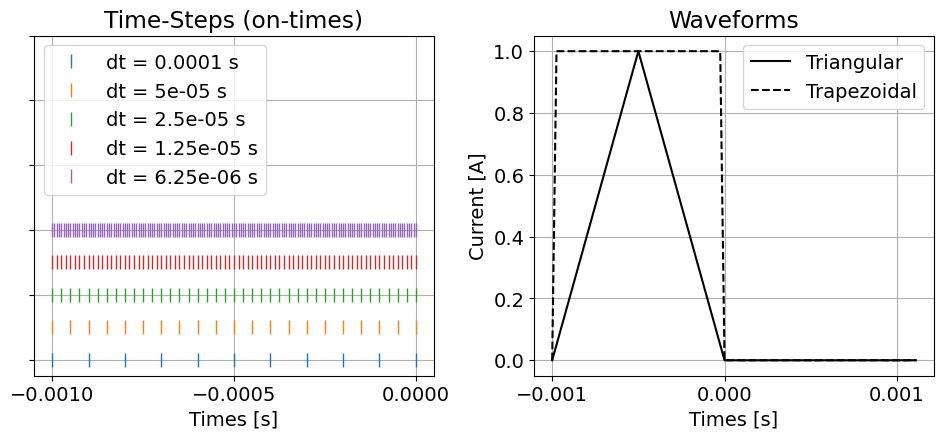

In [18]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
for ii in range(len(on_time_steps_list)):
    t_mesh = TensorMesh([[on_time_steps_list[ii]]], origin=np.array([t0]))
    ax1.plot(t_mesh.nodes_x, ii * np.ones_like(t_mesh.nodes_x), "|", markersize=10)

ax1.set_xticks([-1e-3, -5e-4, 0])
ax1.set_ylim([-0.5, 10])
ax1.set_yticklabels([])
ax1.set_xlabel("Times [s]")
ax1.set_title("Time-Steps (on-times)")
ax1.legend(["dt = {} s".format(x[0]) for x in on_time_steps_list], loc="upper left")
ax1.grid()

plotting_times = np.r_[t_mesh.nodes_x, simulation_times[0]]
ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.plot(plotting_times, [triangular_waveform.eval(t) for t in plotting_times], "k-")
ax2.plot(plotting_times, [trapezoidal_waveform.eval(t) for t in plotting_times], "k--")
ax2.set_xticks([-1e-3, 0, 1e-3])
ax2.set_xlabel("Times [s]")
ax2.set_ylabel("Current [A]")
ax2.set_title("Waveforms")
ax2.grid()
ax2.legend(["Triangular", "Trapezoidal"], loc="upper right")

plt.show()

### Define the Mesh, Model and Mapping

Because the spatial discretization of the problem is consistent for all simulations, the mesh, model and mapping only needs to be generated once. Here, we generate a mesh according to results in Part 1, where the minimum cell size is equal to the minimum diffusion distance.

In [19]:
mesh, model, mapping = generate_discretization(d_min, d_min, d_max)

### Simulation for a Triangular Waveform

Here, we simulate the data for a triangular waveform.

In [20]:
simulation_temp = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(triangular_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1),
)

In [21]:
dpred_triangular = [simulation_temp.dpred(np.array([halfspace_conductivity]))]

for w in on_time_steps_list:
    full_time_steps = [w] + off_time_steps

    simulation_temp = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(triangular_waveform),
        sigmaMap=mapping,
        time_steps=full_time_steps,
        t0=t0,
    )

    dpred_triangular.append(simulation_temp.dpred(model))

### Simulation for a Trapezoidal Waveform

Here, we simulate the data for the trapezoidal waveform.

In [22]:
simulation_temp = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(trapezoidal_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1),
)

In [23]:
dpred_trapezoidal = [simulation_temp.dpred(np.array([halfspace_conductivity]))]

for w in on_time_steps_list:
    full_time_steps = [w] + off_time_steps

    simulation_temp = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(trapezoidal_waveform),
        sigmaMap=mapping,
        time_steps=full_time_steps,
        t0=t0,
    )

    dpred_trapezoidal.append(simulation_temp.dpred(model))

### Results

Because all of the on-time step lengths we tested were sufficiently smaller than the piecewise linear segments comprising the triangular waveform, all of the on-time step lengths we tested produced accurate results. For the trapezoidal waveform however, the time-step length needed to be several times smaller than the length of the ramp-off (2.5e-5 s) in order to produce numerically accurate results.

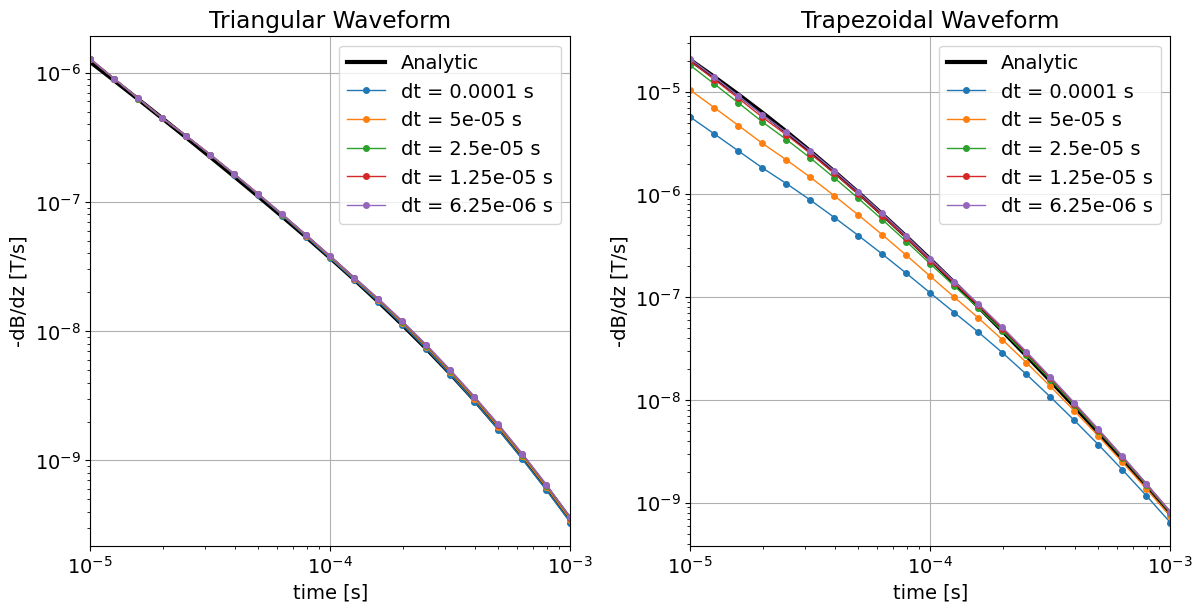

In [25]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
ax1.loglog(time_channels, -dpred_triangular[0], "k", lw=3)
for d in dpred_triangular[1:]:
    ax1.loglog(time_channels, -d, "-o", lw=1, markersize=4)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dB/dz [T/s]")
ax1.set_title("Triangular Waveform")
ax1.legend(
    ["Analytic"] + ["dt = {} s".format(x[0]) for x in on_time_steps_list],
    loc="upper right",
)

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.loglog(time_channels, -dpred_trapezoidal[0], "k", lw=3)
for d in dpred_trapezoidal[1:]:
    ax2.loglog(time_channels, -d, "-o", lw=1, markersize=4)
ax2.set_xlim((np.min(time_channels), np.max(time_channels)))
ax2.grid()
ax2.set_xlabel("time [s]")
ax2.set_ylabel("-dB/dz [T/s]")
ax2.set_title("Trapezoidal Waveform")
ax2.legend(
    ["Analytic"] + ["dt = {} s".format(x[0]) for x in on_time_steps_list],
    loc="upper right",
)

plt.show()